# RAG 정복하기 - written by DaeHyeon Choe

In [ ]:
!pip install langchain \
            langchain-core \
            langchain-community \
            langchain-openai \
            langchain-huggingface
                         

### 이번 실습에서는 LLM에 RAG를 어떻게 사용하는지에 대해 알아볼 예정입니다.
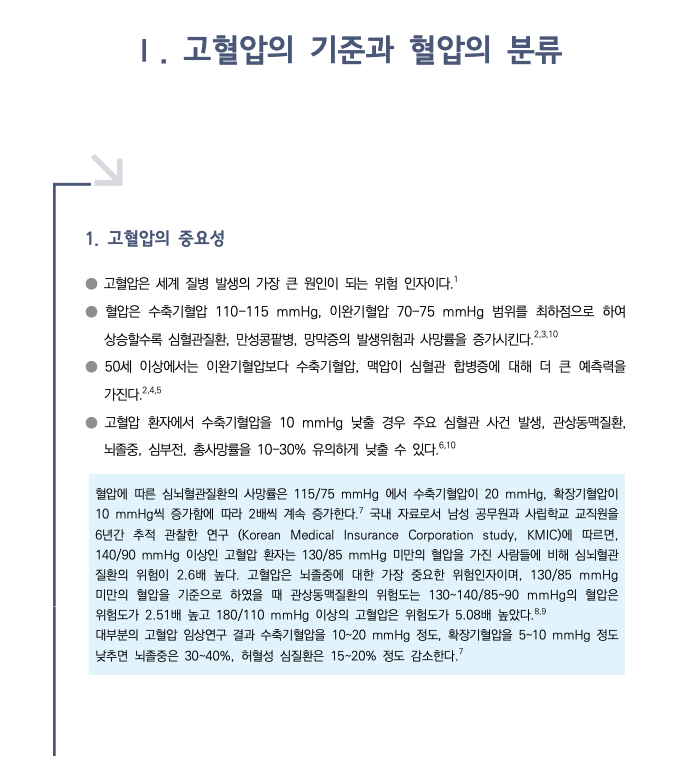
#### 이를 위해 RAG에 넣을 문서인 "[고혈압] 임상진료지침(7차 개정)_전자.pdf" 파일을 사용 할 것입니다.
#### 최종적으로, RAG를 사용하여 특정 질문에 대한 답변을 찾아보는 것이 목표입니다.

### [시스템 이해하기] LLM에 RAG를 사용하기 위해선 초기에는 총 8단계에 걸쳐 모듈을 구성해주어야 합니다. 
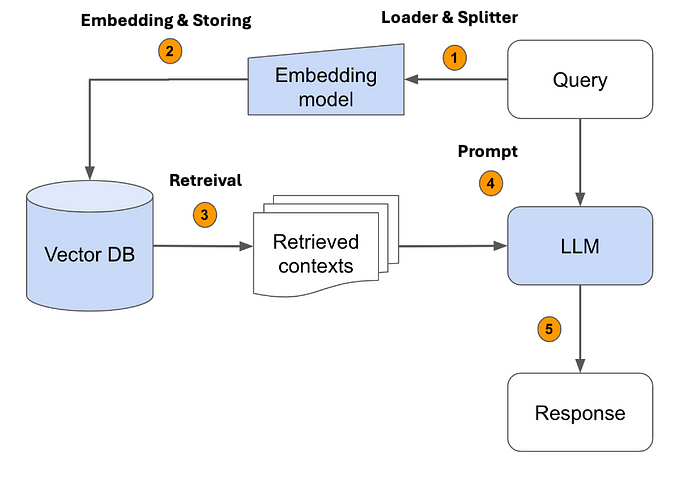


## 8단계 중 핵심 모듈은 아래와 같습니다.
[1] Loader : 사용자가 원하는 파일을 컴퓨터가 읽습니다.

[2] Splitter : 입력된 파일의 내용들을 쪼갭니다.

[3] Embedding : 내용들을 OpenAI의 임베딩 모델을 통해 자연어를 벡터로 변환합니다.

[4] Vectorstore : 벡터로 변환된 값을 Vectorstore에 저장합니다.

[5] Retriever : Vectorstore에 저장된 벡터값을 통해 사용자가 원하는 정보를 찾습니다.

[6] Prompt : 사용자가 질문을 입력합니다.

[7] Model : 사용자가 입력한 질문을 통해 답을 찾습니다.

[8] OutputPaser : 찾은 답을 사용자에게 출력합니다.


### 1. Loader : PDF내에 있는 여러 데이터를 불러와 텍스트 형태로 변환합니다. 

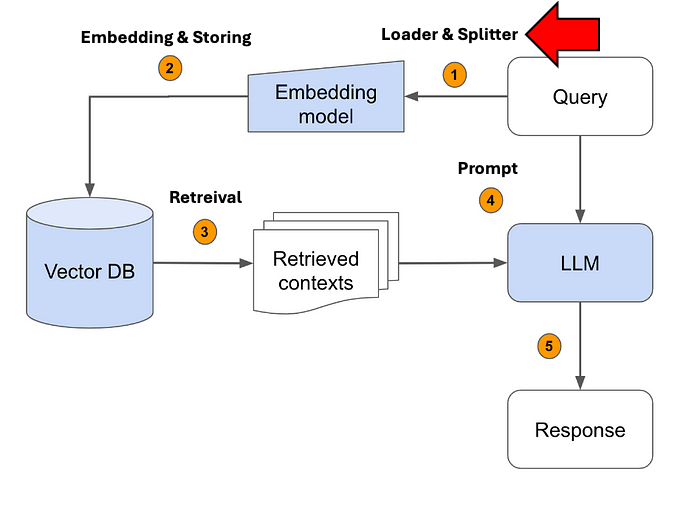
* 여기서는 PDF Loader를 사용합니다.

In [1]:
# 1. Loader
from langchain_community.document_loaders import PyMuPDFLoader
loader = PyMuPDFLoader("./data/[고혈압] 임상진료지침(7차 개정)_전자.pdf") #<-- PDF 파일 경로를 입력하세요
docs =loader.load()

/opt/homebrew/anaconda3/envs/KMEA/lib/python3.10/site-packages/langchain_community/document_loaders/parsers/pdf.py:300: UserWarning: Warning: Empty content on page 3 of document ./data/[고혈압] 임상진료지침(7차 개정)_전자.pdf
  warnings.warn(
/opt/homebrew/anaconda3/envs/KMEA/lib/python3.10/site-packages/langchain_community/document_loaders/parsers/pdf.py:300: UserWarning: Warning: Empty content on page 5 of document ./data/[고혈압] 임상진료지침(7차 개정)_전자.pdf
  warnings.warn(


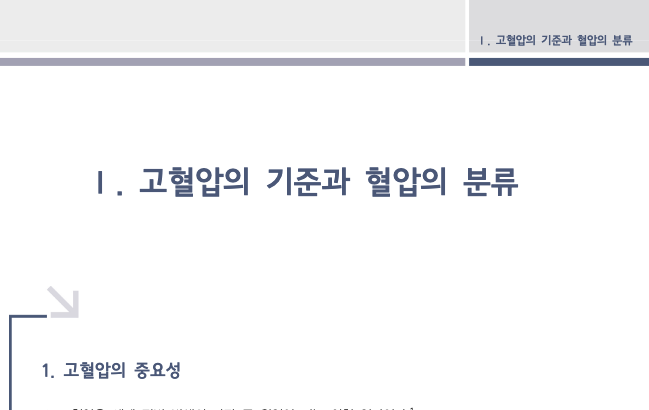

### 1-1. Loader를 통해 불러온 데이터를 확인해봅시다.

In [2]:
print(f"페이지 수 : {len(docs)}page")
print(f"\n[페이지내용]\n{docs[0].page_content[:52]}]")
print(f"\n[메타데이터]\n{docs[0].metadata}")
# 고혈압의 기준과 혈압의 분류와 같이 PDF 파일 내의 내용들을 출력한 것을 확인할 수 있습니다.

페이지 수 : 6page

[페이지내용]
15
Ⅰ. 고혈압의 기준과 혈압의 분류
Ⅰ. 고혈압의 기준과 혈압의 분류
1. 고혈압의 중요성]

[메타데이터]
{'source': './data/[고혈압] 임상진료지침(7차 개정)_전자.pdf', 'file_path': './data/[고혈압] 임상진료지침(7차 개정)_전자.pdf', 'page': 0, 'total_pages': 6, 'format': 'PDF 1.3', 'title': '[고혈압] 임상진료지침(7차 개정)_전자', 'author': 'eiden', 'subject': '', 'keywords': '', 'creator': 'Chrome', 'producer': 'macOS Version 15.1 (Build 24B83) Quartz PDFContext', 'creationDate': "D:20241208142744Z00'00'", 'modDate': "D:20241208142744Z00'00'", 'trapped': ''}


### 2. Splitter : 텍스트 형태로 반환된 내용들을 쪼갭니다.


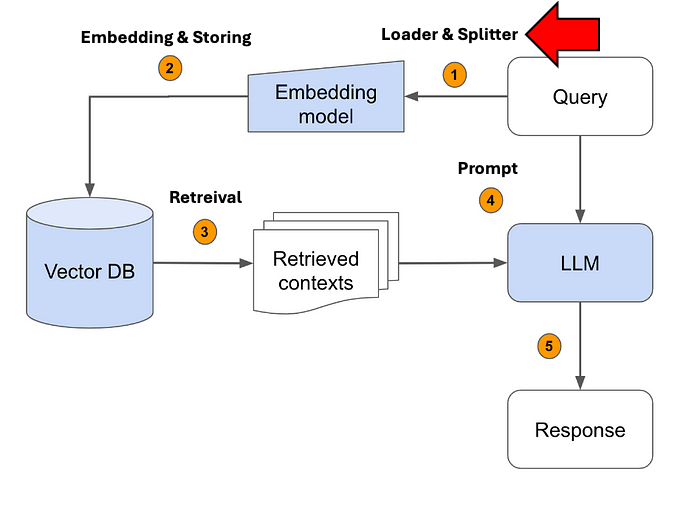

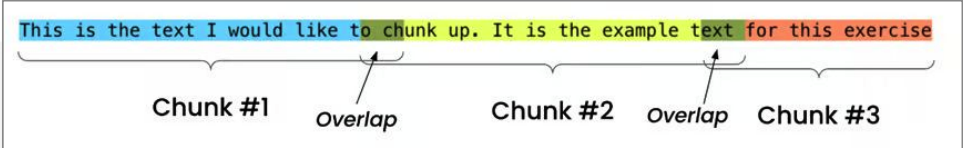

In [3]:
# Text Splitter로 RecursiveCharacterTextSplitter를 사용합니다.
chueck_size = 128
chunk_overlap = 32

from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chueck_size,
    chunk_overlap=chunk_overlap
)

split_docs = text_splitter.split_documents(docs)
print(f"문서를 여러개의 청크로 나눕니다. 문서 내 청크 개수: {len(split_docs)}개")


문서를 여러개의 청크로 나눕니다. 문서 내 청크 개수: 50개


In [4]:
split_docs[25].page_content

'6. Ettehad D, Emdin CA, Kiran A, et al. Blood pressure lowering for prevention of cardiovascular'

In [5]:
split_docs[26].page_content

'disease and death: a systematic review and meta-analysis. Lancet 2016;387(10022):957-67.'

In [6]:
# 청크별로 글자 길이수가 다르게 분할된 것을 확인할 수 있다.
print(f"25번쨰 청크 길이 수 : {len(split_docs[25].page_content)}자")
print(f"26번쨰 청크 길이 수 : {len(split_docs[26].page_content)}자")

25번쨰 청크 길이 수 : 96자
26번쨰 청크 길이 수 : 88자


## 3. Embedding : Chunk 단위로 분리한 데이터를 벡터화하기 위해 임베딩 모델을 사용합니다.
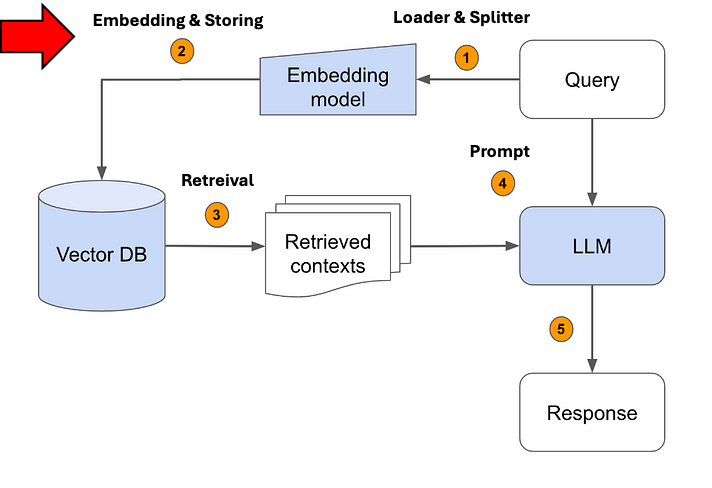
### * Embedding 모델은 여러 모델이 존재하니 (Huggingface)와 OpenAI사의 Embedding 모델을 다양하게 사용해보세요.
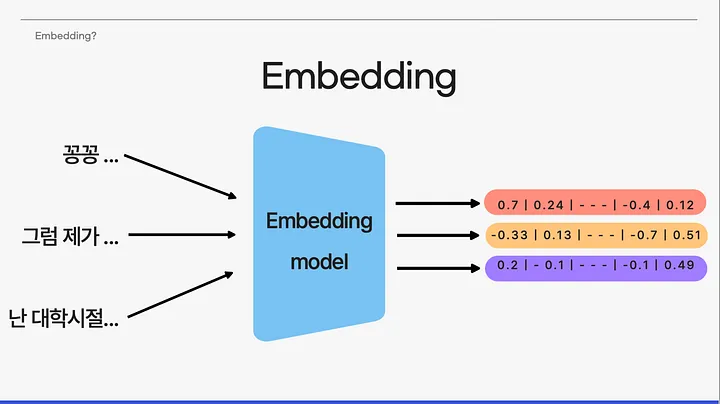

### 자연어를 벡터로 변환해 의미가 비슷한 단어들끼리 관계를 형성합니다.
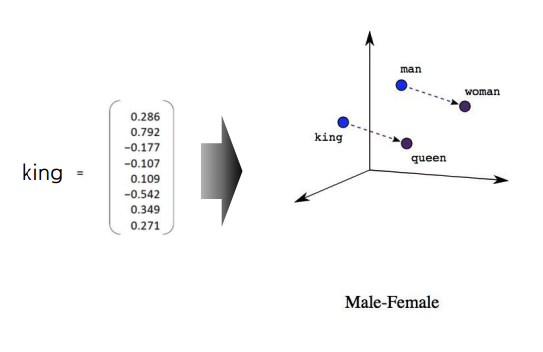

In [7]:
# 3-1. 임베딩 모델을 OpenAI에서 제공하는 임베딩 모델로 설정합니다.
from langchain_openai import OpenAIEmbeddings


embeddings = OpenAIEmbeddings(
    openai_api_key = "", # <-- OpenAI API Key를 입력하세요
) # OpenAI 임베딩 모델을 사용합니다.

In [8]:
# # 3-2. 임베딩 모델을 Hugging Face에서 제공하는 임베딩 모델로 설정합니다.
# from langchain_huggingface import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(
#     model_name='jhgan/ko-sroberta-nli', # <-- Hugging Face에서 제공하는 임베딩 모델명을 입력하세요
#     model_kwargs={'device':'cpu'}, # <-- 임베딩 모델의 인자를 입력하세요
#     encode_kwargs={'normalize_embeddings':True}, # <-- 임베딩 모델의 인코딩 인자를 입력하세요
# )

## 4. Vectorstore : 벡터화된 데이터를 저장하는 Vectorstore를 만들고, VectorStore에서 데이터를 검색합니다.

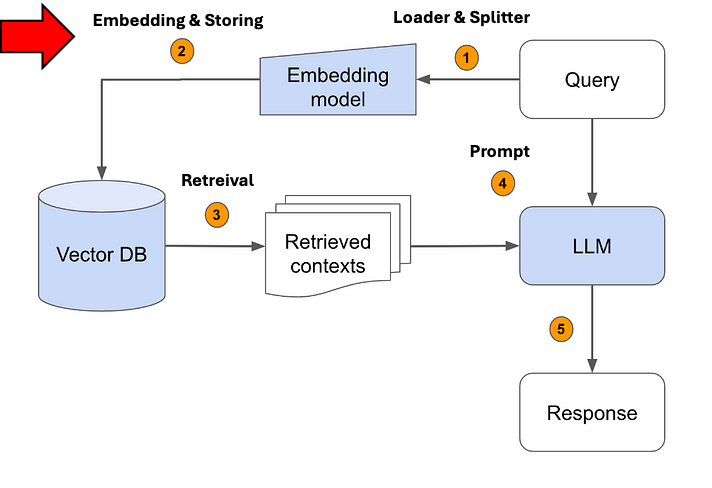

In [9]:
# Vector Store를 생성합니다. 
from langchain_community.vectorstores import FAISS
vector_store = FAISS.from_documents(
    documents = split_docs, # Loader와 Splitter를 통해 생성된 문서를 입력합니다.
    embedding = embeddings, # 임베딩 모델을 설정합니다. OpenAI 또는 Hugging Face 임베딩 모델을 사용할 수 있습니다.
)

## 5. Retriever : Vectorstore에서 데이터를 Retrieve하기 위해 사용합니다.
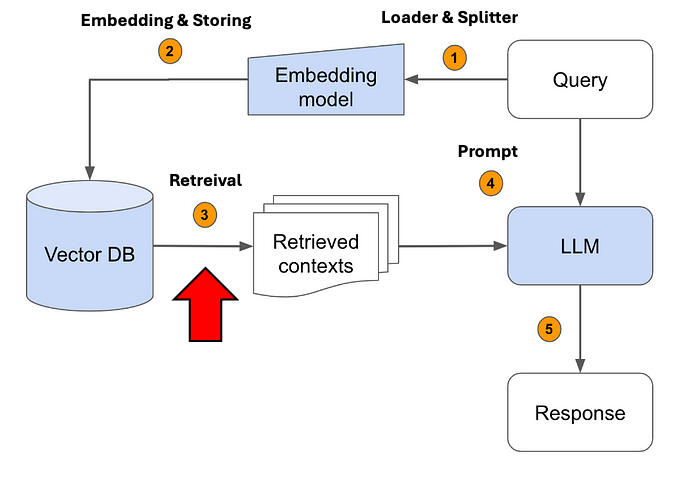


In [10]:
retriever = vector_store.as_retriever(
    search_type="mmr", # <--- 검색 방식을 설정합니다 [mmr, similarity]
    search_kwargs={
        "k": 1,  # <--- k: 검색 결과 중 반환할 청크 개수를 설정합니다.
        "fetch_k": 1,  # <--- fetch_k: 검색 시 고려할 후보 문서의 수를 설정합니다.
        "lambda": 0.5  # <--- lambda: MMR(Maximal Marginal Relevance)에서 다양성과 유사성 간의 가중치를 조정하는 파라미터입니다.
    }
)

## 5+ Retriver를 통해 PDF에 있던 내용을 Vectore store에서 가져와 확인해봅니다.

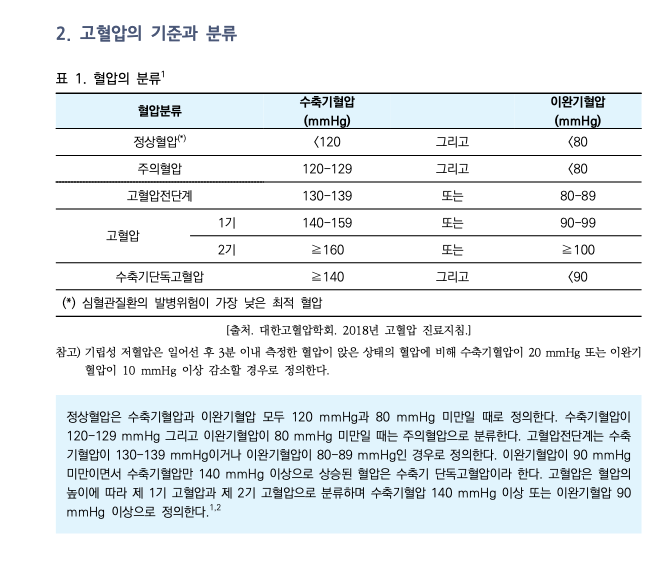

In [32]:
query = "수축기혈압과 이완기혈압 정의에 대해 알려주세요." #<-- 검색할 내용을 입력하세요.

# 5+ chunk 결과 확인
referenece = retriever.invoke(query) # Vector Store를 통해 검색을 수행합니다.

In [33]:
print(f"참고 문장 개수 : {len(referenece)}")
for i, ref in enumerate(referenece):
    print(f"참고 문장 {i+1} : {ref.page_content}")
    print("참고 페이지 : ", ref.metadata['page']+1, "페이지")

참고 문장 개수 : 1
참고 문장 1 : 높이에 따라 제 1기 고혈압과 제 2기 고혈압으로 분류하며 수축기혈압 140 mmHg 이상 또는 이완기혈압 90 
mmHg 이상으로 정의한다.1,2
참고문헌
참고 페이지 :  3 페이지


### 6. 이제 LLM에 들어갈 프롬프트를 만듭니다. 질문과 RAG를 통해 나온 참고 내용들을 Prompt로 넣어줍니다.

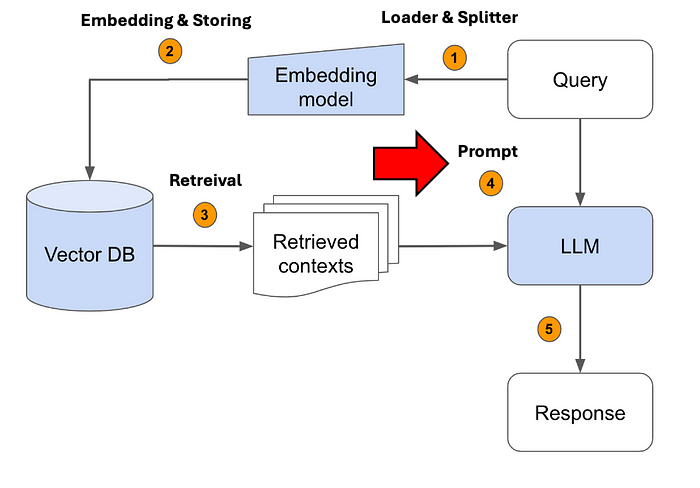

In [48]:
# 6. 프롬프트 생성 
from langchain_core.prompts import PromptTemplate
"""
- 프롬프트 구성
1. 자격부여
2. 출력 조건 제시
3. 질문
4. RAG결과내용(문서를 임베딩한 벡터 스토어에서 검색된 참고 내용) 
4. 답변
"""
# Context가 포함되게 프롬프트를 구성합니다.
prompt = PromptTemplate.from_template(
    """
    당신은 대한민국 의대 출신의 전 세계 1위 의사입니다. 질문에 답변할 때는 항상 신뢰할 수 있는 정보와 RAG로 제공된 Context를 기반으로 답변하세요. 

    - 반드시 RAG에서 제공된 Context를 최대한 활용하세요.
    - Context 외의 내용을 추가할 때는 사실과 다르지 않은 신뢰할 수 있는 정보를 사용하세요.
    - Context에 없는 내용을 추측하지 마세요.
    - 모든 답변은 한국어로 작성하세요.
    - 친절하고 전문적인 어조를 유지하세요.

    Context:
    {context}

    질문:
    {question}

    답변:
    """

)



## 7. LLM Model을 정의합니다.

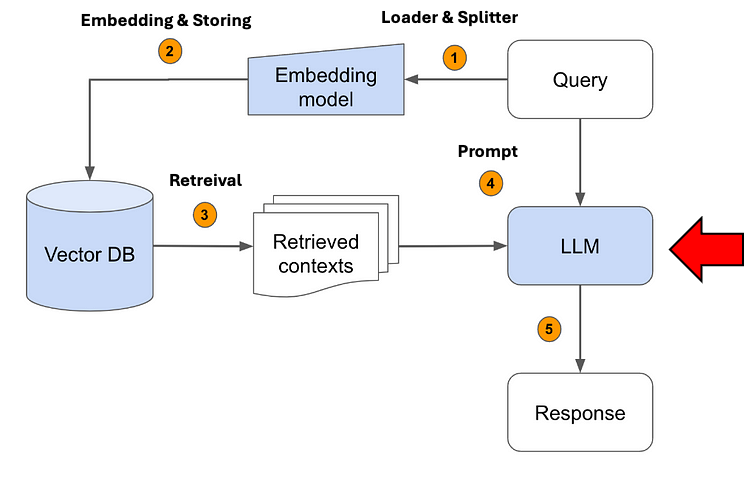

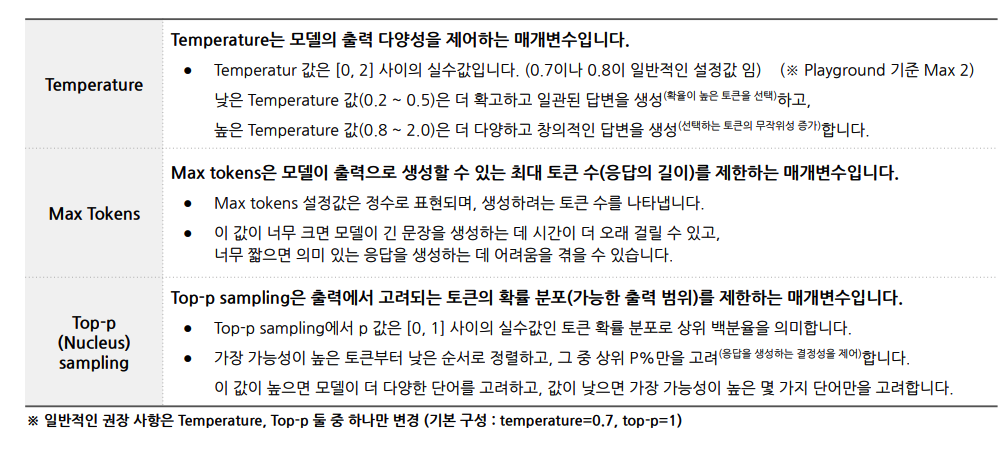

In [39]:
# 7. LLM 모델 생성
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key = "", # <-- OpenAI API Key를 입력하세요
    model_name = 'gpt-3.5-turbo', # <-- OpenAI에서 제공하는 LLM 모델명을 입력하세요
    temperature = 0, #<-- 확고한 대답 : 0, 창의적인 대답 : 1
    top_p = 0 # <-- 다양한 답변을 원할 때 : 1, 확고한 답변을 원할 때 : 0
)

## 8. Chain을 생성합니다. 이를 통해 사용자가 llm모델을 사용하듯이 RAG를 사용할 수 있습니다. 

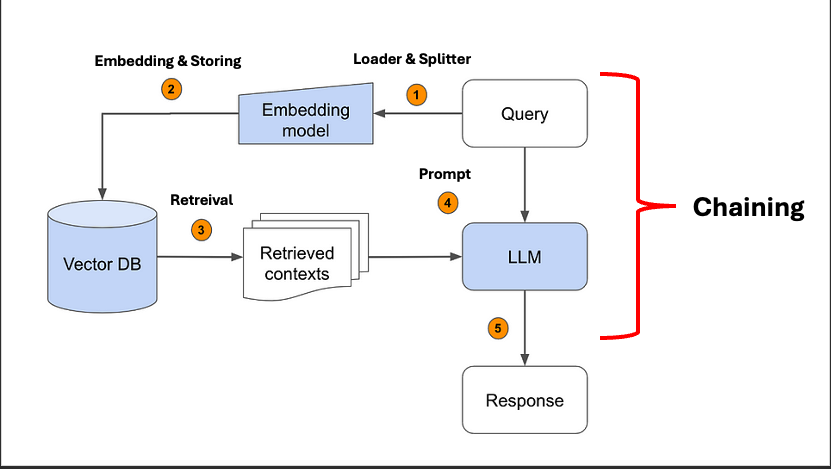

#### Chaining : Chain 구성

In [49]:
from langchain_core.output_parsers.string import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    """ 검색한 문서 결과를 metadata를 제외하고 내용만 사용해 하나의 문단으로 합치는 함수. """
    return "\n\n".join([doc.page_content for doc in docs])
chain = (
    {"question": RunnablePassthrough(), "context": retriever | format_docs}
    | prompt
    | llm
    | StrOutputParser()
)

## 9 RAG와 RAG를 사용하지 않은 경우의 결과를 비교해봅시다.

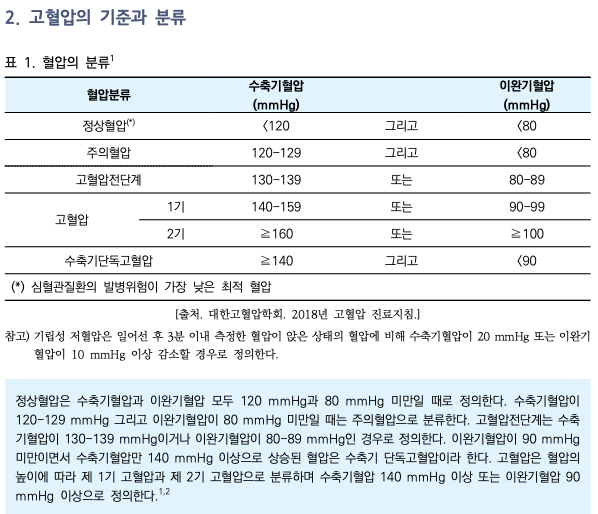

In [50]:
# 9. 체인 실행 및 결과 확인
# # 테스트 질문
query = "고혈압 환자는 일반 환자보다 심뇌혈관 질환 위험이 몇배 높지?" #<-- 검색할 내용을 입력하세요.
response = chain.invoke(query)
print(f"[질문] : {query}\n")

# retrieval 결과 확인
referenece = retriever.invoke(query) # Vector Store를 통해 검색을 수행합니다.
for i, ref in enumerate(referenece):
    print("참고 페이지 : ", ref.metadata['page']+1, "페이지")
    print(f"참고 문장 {i+1} : {ref.page_content}")
    
print(f"\n[LLM결과] : {response}\n")

[질문] : 고혈압 환자는 일반 환자보다 심뇌혈관 질환 위험이 몇배 높지?

참고 페이지 :  1 페이지
참고 문장 1 : 140/90 mmHg 이상인 고혈압 환자는 130/85 mmHg 미만의 혈압을 가진 사람들에 비해 심뇌혈관
질환의 위험이 2.6배 높다. 고혈압은 뇌졸중에 대한 가장 중요한 위험인자이며, 130/85 mmHg

[LLM결과] : 고혈압 환자는 일반 환자보다 심뇌혈관 질환 위험이 2.6배 높습니다.



## +) LLM만 사용했을때 결과를 확인해봅시다.

In [51]:
query = "고혈압 환자는 일반 환자보다 심뇌혈관 질환 위험이 몇배 높지?" #<-- 검색할 내용을 입력하세요.
raw_output = llm.invoke(query)

print(raw_output.content)

고혈압 환자는 일반 환자보다 심뇌혈관 질환 위험이 약 4배 높습니다. 고혈압은 혈압이 지속적으로 높은 상태로 유지되는 질병으로, 혈압이 높을수록 심뇌혈관 질환 발생 위험이 증가합니다. 고혈압을 조절하고 적절한 치료를 받는 것이 중요합니다.
